In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## Credit Risk Prediction Project

Date: July 2025

Author: Natalia Blanco

Type: Classification Problem

Description: The goal of this analysis is to develop a model that asseses whether an individual as demonstrated 90 days past due delinquency or worse dependign on finanxial features and individual characteristics. This project will use the "Give Me Some Credit" dataset from Kaggle. 

Credit Fusion and Will Cukierski. Give Me Some Credit. https://kaggle.com/competitions/GiveMeSomeCredit, 2011. Kaggle.

In [2]:
credit_traindf = pd.read_csv("data/cs-training.csv")
credit_testdf = pd.read_csv("data/cs-test.csv")

In [3]:
credit_traindf

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


The training dataset contains long confusing columns, these will be rennamed to simplify the features. Also, one of the columns will be removed because it is not useful, appears to be the index column ("Unnamed : 0").

In [4]:
credit_traindf = credit_traindf.rename(columns = {
    "SeriousDlqin2yrs" : "target",
    "RevolvingUtilizationOfUnsecuredLines" : "credit_util_ratio",
    "NumberOfTime30-59DaysPastDueNotWorse" : "mod_late_count_2yr",
    "DebtRatio": "debt_ratio",
    "MonthlyIncome" : "monthly_income",
    "NumberOfOpenCreditLinesAndLoans" : "credit_loans_count", 
    "NumberOfTimes90DaysLate" : "crit_late_count", 
    "NumberRealEstateLoansOrLines" : "real_estate_count",
    "NumberOfTime60-89DaysPastDueNotWorse"  :"sev_late_count_2yr",
    "NumberOfDependents" : "dependent_count"
})

credit_traindf


,Unnamed: 0,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [5]:
credit_traindf = credit_traindf.drop(columns = ["Unnamed: 0"])
credit_traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   target              150000 non-null  int64  
 1   credit_util_ratio   150000 non-null  float64
 2   age                 150000 non-null  int64  
 3   mod_late_count_2yr  150000 non-null  int64  
 4   debt_ratio          150000 non-null  float64
 5   monthly_income      120269 non-null  float64
 6   credit_loans_count  150000 non-null  int64  
 7   crit_late_count     150000 non-null  int64  
 8   real_estate_count   150000 non-null  int64  
 9   sev_late_count_2yr  150000 non-null  int64  
 10  dependent_count     146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


Observing the dataset, it appears that the features for monthly income and dependent count contain missing values. The monthly income is particularly not good because there is about 20% of the data missing, and another column, the debt ratio is directly affected. The debt ratio is calculated by dividing monthly debt payments, alimony and living costs by the monthly income. But for rows containing a missing monthly income, the debt ratio is a whole number (not ratio), indicating that those examples were not correctly calucated with the monthly income, and instead may have been computed simply by dividing by 1. Since we are not sure what the monthly income is, we cannot be confident in the debt ratio. The depenedent count is less severe and only accounts for about 7 percent of the total data. 

We will use the KNNImputer to imptute the missing values in monthly income and create a custom transformer to update the debt ratio, called update_dept_ratio. Could potentially also create a missingness flag in feature engineering. We could remove the rows that do not contain the dependent count, since there is a much lesser number of these cases.

### 1. Exploratory Data Analysis

> There is a moderate class imbalance for the target feature, there is notably more cases of individuals that do not have a 90+ due dilenquency (~93%), and individuals with this characteristic is the minority (~7%). This could risk of the model overfitting, and not doing well on the minority class, we need to ensure that downstream metric results acknowledge this.  

> Some of the data appears to have outliers based on the statistics summary, there are very large max values. This will be further investigated. There is also some weird data such as the min age at 0. Based on summary statistics moderate/severe/crit late counts are not very common, but appear to be very high for a select few people (not within the IQR ranges). 

> From the boxplots, we see that there are many outliers in the data. The columns that show particularly a few extreme values include age,  the columns that are particular concerning are age, credit utiliation ratio, moderate/severe/crit late counts and credit utilization ratio. We can modify these by eliminated the extreme outliers. 
Note that the debt ratio column also has notably large outliers, but this may becuase some of the data is not properly normalized due to the missing monthly income, we can check this again once the monthly income column is imputed. The

> From the heatmap, we see that there are high positive correlations between moderate late count (2 years), severe late count (2 years) and critical late count. Our options are to eliminate two of these features or perform feature engineering to combine them or create a new features. 

Individuals in this dataset with 90+ days past due Delinquency: 10026 (6.68%)
Individuals in this dataset without 90+ days past due Delinquency: 139974 (93.32%)


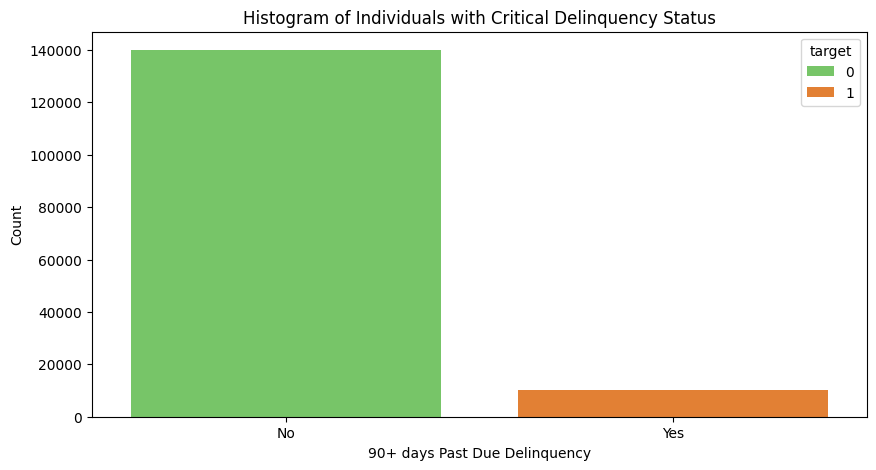

In [6]:
# Make a histogram displaying the counts of the target column

yes_cases = credit_traindf[credit_traindf["target"] == 1].shape[0]
no_cases = credit_traindf[credit_traindf["target"] == 0].shape[0]
total = credit_traindf.shape[0]

yes_cases_percent, no_cases_percent = (yes_cases / total)*100, (no_cases / total)*100

print(f"Individuals in this dataset with 90+ days past due Delinquency: {yes_cases} ({yes_cases_percent:.2f}%)")
print(f"Individuals in this dataset without 90+ days past due Delinquency: {no_cases} ({no_cases_percent:.2f}%)")


plt.figure(figsize = (10,5))
sns.countplot(x = "target",
              data = credit_traindf,
              hue = "target", 
              palette={0 : "#6DD558", 1 : "#FF7C17"})
plt.title("Histogram of Individuals with Critical Delinquency Status")
plt.xlabel("90+ days Past Due Delinquency")
plt.ylabel("Count")
plt.xticks(ticks = [0, 1], labels=['No', 'Yes'])
plt.show()

In [7]:
credit_traindf.describe()

,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


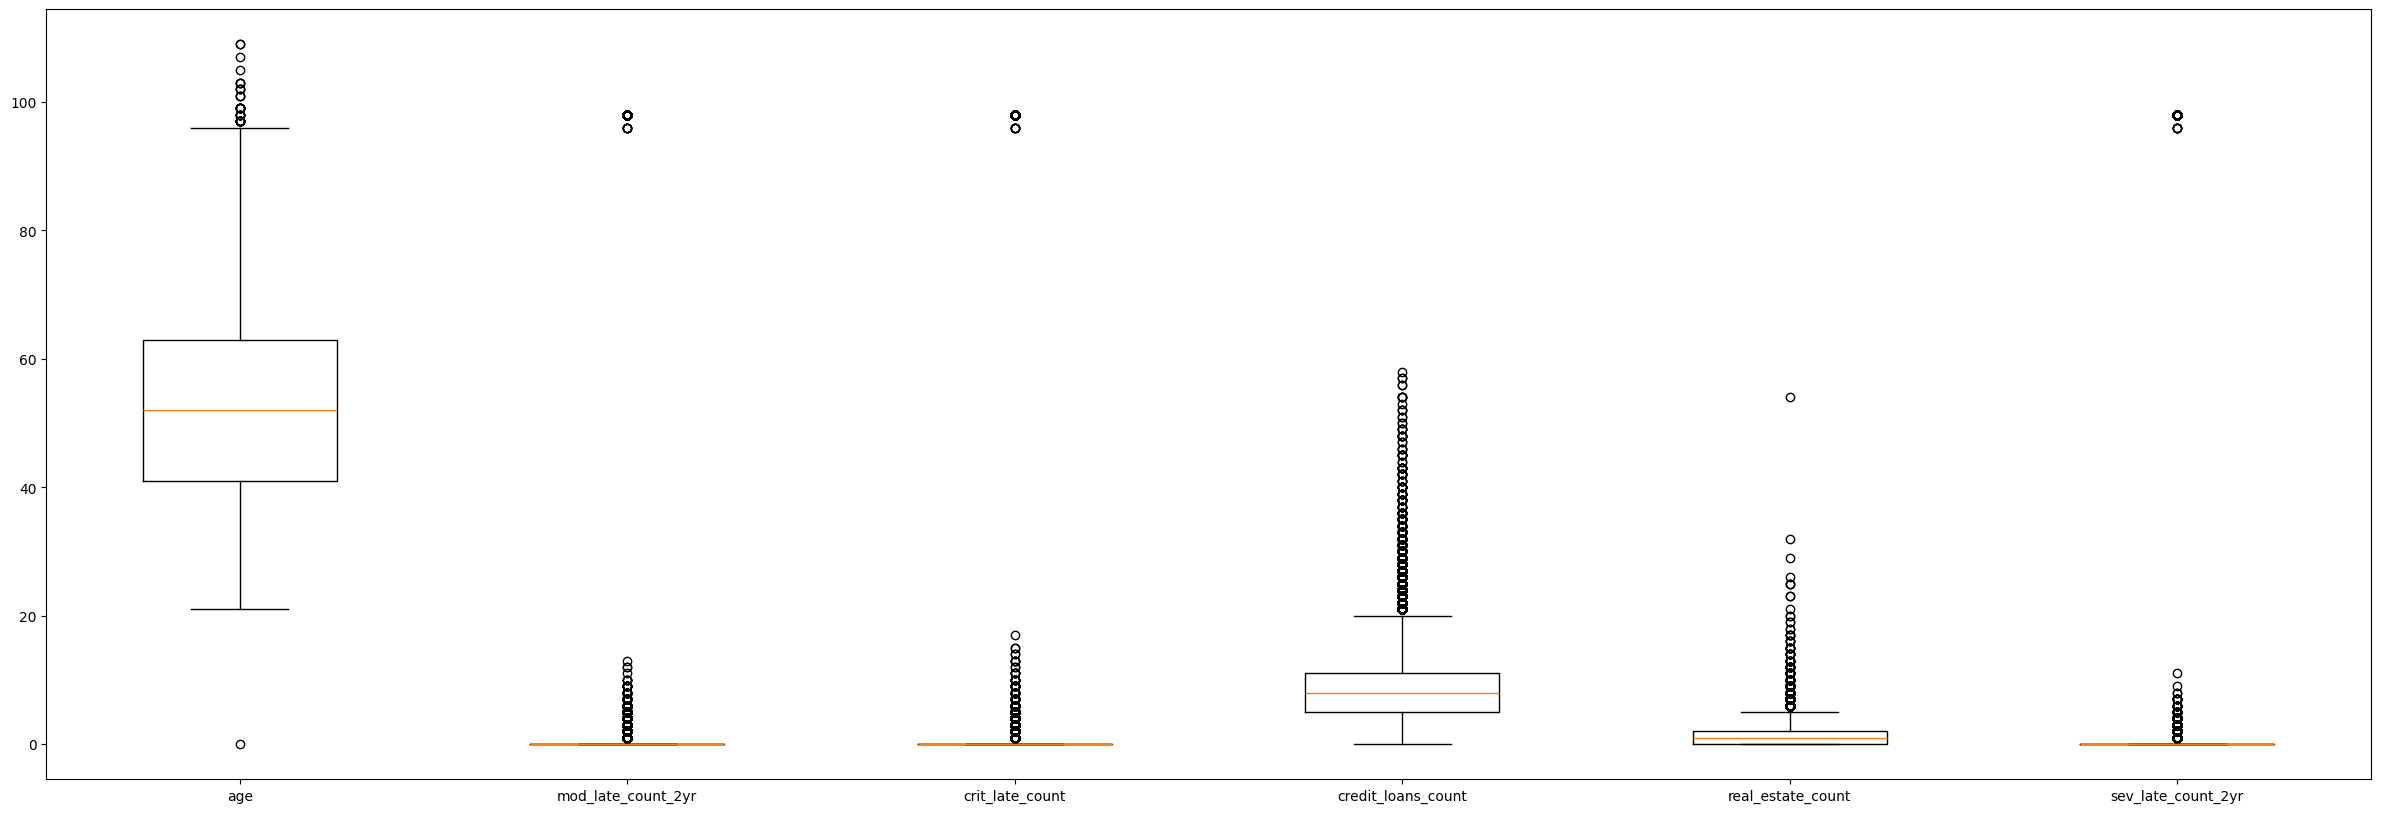

In [8]:
columns_0 = credit_traindf[["age", "mod_late_count_2yr", "crit_late_count", "credit_loans_count", "real_estate_count", "sev_late_count_2yr"]]

plt.figure(figsize = (30,10))
plt.boxplot(columns_0)
plt.xticks(ticks = range(1,7), labels = columns_0)
plt.show()

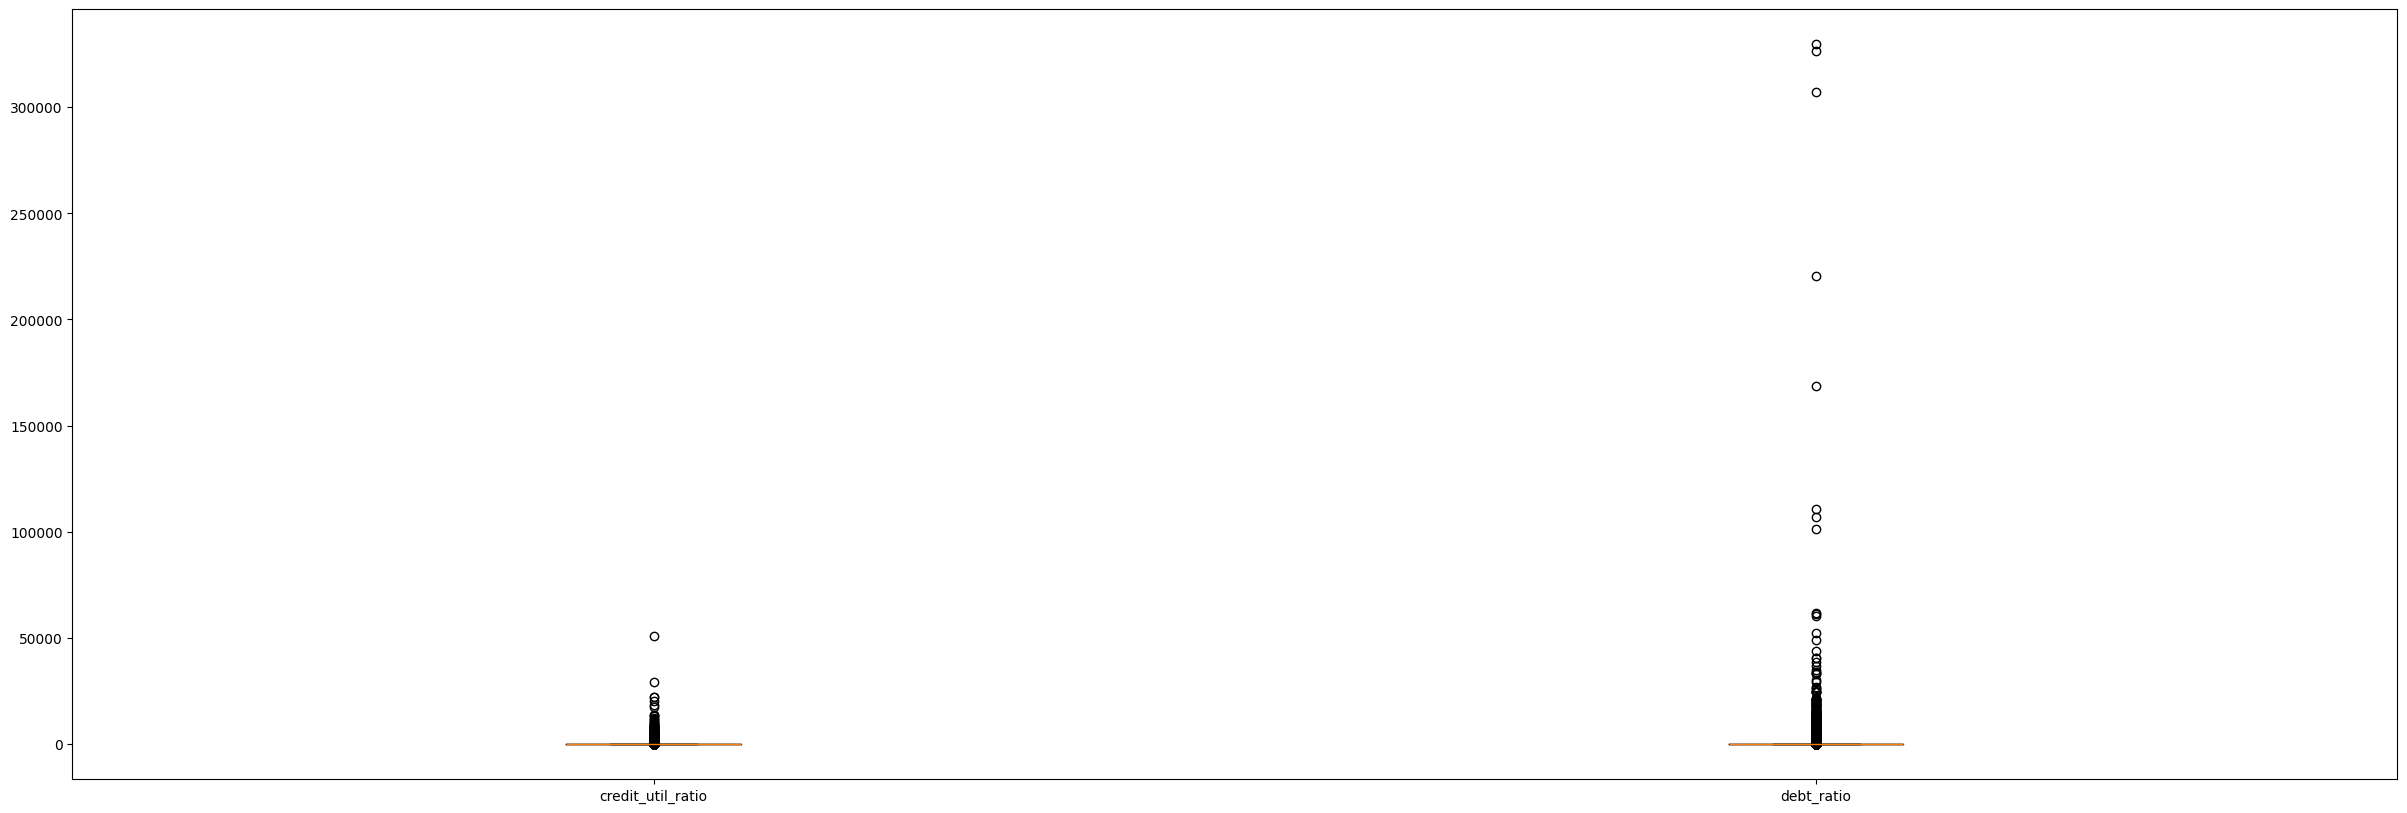

In [9]:
columns_1 = credit_traindf[["credit_util_ratio", "debt_ratio"]]

plt.figure(figsize = (30,10))
plt.boxplot(columns_1)
plt.xticks(ticks = range(1,3), labels = columns_1)
plt.show()

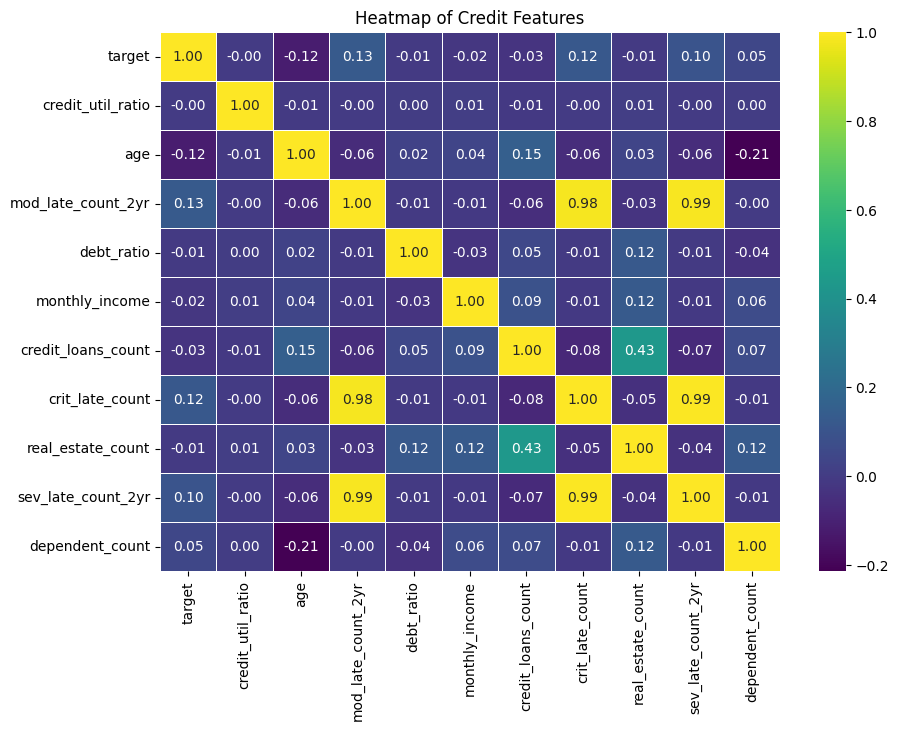

In [10]:
# Create a Heatmap to show correlations between features
corr_subset = credit_traindf[credit_traindf.columns[:1000]].corr()


plt.figure(figsize=(10, 7)) 
sns.heatmap(corr_subset, annot=True, cmap='viridis', fmt=".2f", linewidths=.5) 
plt.title('Heatmap of Credit Features') 
plt.show()

### 2. Feature Engineering

> Really useful look, should look into afterwards: https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets

> For feature engineering, we will ignore the class imbalance for now, it is moderate so we will first see how the models react before improving this. We will trim some of the columns that appear to have extreme outliers as mentioned in the EDA. Finally, we will try averaging the values with high correlations to reduce the risk of multicolinearity.

In [11]:
# Average moderate late count and severe late counts

credit_traindf["avg_late_count"] = (credit_traindf["mod_late_count_2yr"] + credit_traindf["sev_late_count_2yr"] + credit_traindf["crit_late_count"]) / 2

In [12]:
# Remove outliers from age, credit util ratio and avg late count (the features that were engineered for this column all showed extreme outliers)

def remove_outliers(df, columns) : 

    df_clean = df.copy()

    for col in columns : 
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR

        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

In [17]:
# Not going to correct the avg_late_count because it will just make all the rows zero (majoority of the rows are zero, only a few oitliers are high in this category)

credit_traindf_cleaned = remove_outliers(credit_traindf, ["age","credit_util_ratio"])

In [18]:
credit_traindf_cleaned.describe()

,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count,avg_late_count
count,149191.000000,149191.000000,149191.000000,149191.000000,149191.000000,1.196670e+05,149191.000000,149191.000000,149191.000000,149191.000000,145305.000000,149191.000000
mean,0.065607,0.317054,52.314449,0.419757,353.236469,6.672465e+03,8.468312,0.263005,1.020082,0.239311,0.756953,0.461037
std,0.247595,0.349767,14.750598,4.203386,2041.677604,1.441378e+04,5.147756,4.178607,1.130330,4.165860,1.114910,6.249132
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029607,41.000000,0.000000,0.175275,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.151988,52.000000,0.000000,0.366546,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.549449,63.000000,0.000000,0.866514,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,1.000000,1.352159,96.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000,147.000000
